# Electricity Demand Forecasting

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    1. [Clean Data Frame](#clean_data)<br>
    2. [Data Split](#data_split)<br>




### <a id='import'> 1. Import Modules</a>

In [101]:
import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

#from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel
from fbprophet import Prophet

In [102]:
warnings.filterwarnings('ignore')

### 2. Data Import <a id='read_data'></a>

In [103]:
data_file = '../data/big_demand_temp_train_by_day.csv'

In [104]:
full_df = pd.read_csv(data_file, index_col=0)
full_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0


#### 2.A Clean the data frame <a id='clean_data'></a>

In [105]:
# Convert the time string to a datetime object
full_df.index = pd.DatetimeIndex(full_df.index)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 852 entries, 2015-07-06 to 2017-11-03
Data columns (total 9 columns):
day_demand    852 non-null float64
CA_pop        852 non-null float64
la_high       852 non-null float64
sd_high       852 non-null float64
sj_high       852 non-null float64
sf_high       852 non-null float64
sac_high      852 non-null float64
f_high        852 non-null float64
DOW           852 non-null float64
dtypes: float64(9)
memory usage: 66.6 KB


In [106]:
full_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0


#### 2.B Extending Exogenous Regressors To Include Day Of Week <a id='extend_dow'></a>

In [107]:
days = full_df['DOW']
days_df = pd.get_dummies(days)
days_df.columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days_df.index = full_df.index
new_df = pd.concat([full_df, days_df], axis=1)
col_names = []
col_names.extend(full_df.columns)
col_names.extend(days_df.columns)
new_df.columns = col_names
new_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,Mon,Tue,Wed,Thur,Fri,Sat,Sun
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0,1,0,0,0,0,0,0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0,0,1,0,0,0,0,0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0,0,0,1,0,0,0,0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0,0,0,0,1,0,0,0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0,0,0,0,0,1,0,0


#### 2.C Data Split <a id='data_split'></a>

In [108]:
# Split the data into training and test sections
data_len = new_df.shape[0]

In [109]:
# Split the data frame into two parts
train_len = int(0.7 * data_len)
window_len = int(0.1 * data_len)

In [110]:
# Make the primary train/validation split
X_train = new_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = new_df.iloc[train_len:train_len+window_len, :]
X_walk2 = new_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = new_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [111]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 2015-07-06 to 2017-02-20
Data columns (total 16 columns):
day_demand    596 non-null float64
CA_pop        596 non-null float64
la_high       596 non-null float64
sd_high       596 non-null float64
sj_high       596 non-null float64
sf_high       596 non-null float64
sac_high      596 non-null float64
f_high        596 non-null float64
DOW           596 non-null float64
Mon           596 non-null uint8
Tue           596 non-null uint8
Wed           596 non-null uint8
Thur          596 non-null uint8
Fri           596 non-null uint8
Sat           596 non-null uint8
Sun           596 non-null uint8
dtypes: float64(9), uint8(7)
memory usage: 50.6 KB


----
----
#### Walk Forward
----

In [112]:
full_df['log_demand'] = np.log(full_df['day_demand'])
full_df['ds'] = full_df.index
full_df['y'] = full_df['day_demand']

In [113]:
full_df.shape

(852, 12)

In [114]:
def data_block(X, start, out_size) :
    # get the slices of data frames to provide the blocks requested
    block1 = X.iloc[start:start+out_size, :]
        
    return block1
    

In [115]:
def prophet_walk_forward_val(data, start_size, val_window, regressors, steps) :
    '''
        Function: walk_forward_val
        
        Arguments:
            model - model class instantiator
            data - pandas dataframe containing data of interest
            start_size - initial number of rows for training
            val_window - size of the validation window for each trail
            regressors - list of regressors to add to the model
            steps - number of walk forward steps to run
        
        Return:
            mape_list - list of tupels with the last index for training window and mape for the window
    '''
    mape_list = []
    # for each steps
    for step in range(steps) :
        print(start_size+step*val_window)
        # Get the block of data for training
        train_dat = data_block(data, 0, start_size+step*val_window)
        
        # Get a block of data for validation
        val_dat = data_block(data, start_size+step*val_window, val_window)
        
        # Instantiate the model
        m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
        
        # Add regressors
        for reg in regressors :
            m.add_regressor(reg)
            
        # Fit the model
        m.fit(train_dat)
        
        # Forecast for the validation step
        forecast = m.predict(val_dat)
        forecast.index = val_dat.index
        print(forecast['ds'].values[0], val_dat['ds'].values[0])
        
        # Caluclate the MAPE for the window
        ape = [np.abs(val_dat.loc[x, 'y'] - forecast.loc[x, 'yhat']) / val_dat.loc[x, 'y'] * 100 for x in val_dat.index]
        
        # Add the values to the list
        mape_list.append((train_dat.index[-1], np.mean(ape)))
        
    # return the mape list
    return mape_list

In [116]:
def sarimax_walk_forward_val(data, start_size, val_window, regressors, steps) :
    '''
        Function: sarimax_walk_forward_val
        
        Arguments:
            model - model class instantiator
            data - pandas dataframe containing data of interest
            start_size - initial number of rows for training
            val_window - size of the validation window for each trail
            regressors - list of regressors to add to the model
            steps - number of walk forward steps to run
        
        Return:
            mape_list - list of tupels with the last index for training window and mape for the window
    '''
    # Now choose the results that seem to work the best above and fit the model

    best_order3 = (5, 0, 0)
    best_seasonal_order3 = (3, 0, 1, 7)
    
    mape_list = []
    # for each steps
    for step in range(steps) :
        print(start_size+step*val_window)
        # Get the block of data for training
        train_dat = data_block(data, 0, start_size+step*val_window)
        
        # Get a block of data for validation
        val_dat = data_block(data, start_size+step*val_window, val_window)
        

        model = SARIMAX(data['log_demand'], order=best_order3, \
                    seasonal_order=best_seasonal_order3, exog=data[exog_columns])
        res = model.fit()
        
        # Forecast for the validation step
        predict = res.get_forecast(val_window, exog=val_dat[regressors].values[:val_window, :])
        
        forecast = np.exp(predict.predicted_mean)
        
        # Caluclate the MAPE for the window
        ape = [np.abs(val_dat['day_demand'].values[x] - forecast[x]) / val_dat['day_demand'].values[x] * 100 for x in range(len(val_dat.index))]
        
        # Add the values to the list
        mape_list.append((train_dat.index[-1], np.mean(ape)))
        
    # return the mape list
    return mape_list

In [117]:
exog_columns = ['la_high','f_high']
results = sarimax_walk_forward_val(full_df, 432, 21, exog_columns, 20)

432
453
474
495
516
537
558
579
600
621
642
663
684
705
726
747
768
789
810
831


In [118]:
exog_columns = ['CA_pop', 'la_high', 'sd_high', 'f_high', 'sj_high', 'sf_high', 'sac_high']
results_prophet = prophet_walk_forward_val(full_df, 432, 21, exog_columns, 20)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


432


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-09-10T00:00:00.000000000 2016-09-10T00:00:00.000000000
453


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-10-01T00:00:00.000000000 2016-10-01T00:00:00.000000000
474


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-10-22T00:00:00.000000000 2016-10-22T00:00:00.000000000
495


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-11-12T00:00:00.000000000 2016-11-12T00:00:00.000000000
516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-12-03T00:00:00.000000000 2016-12-03T00:00:00.000000000
537


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-12-24T00:00:00.000000000 2016-12-24T00:00:00.000000000
558


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-01-14T00:00:00.000000000 2017-01-14T00:00:00.000000000
579


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-02-04T00:00:00.000000000 2017-02-04T00:00:00.000000000
600


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-02-25T00:00:00.000000000 2017-02-25T00:00:00.000000000
621


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-03-18T00:00:00.000000000 2017-03-18T00:00:00.000000000
642


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-04-08T00:00:00.000000000 2017-04-08T00:00:00.000000000
663


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-04-29T00:00:00.000000000 2017-04-29T00:00:00.000000000
684


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-05-20T00:00:00.000000000 2017-05-20T00:00:00.000000000
705


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-06-10T00:00:00.000000000 2017-06-10T00:00:00.000000000
726


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-07-01T00:00:00.000000000 2017-07-01T00:00:00.000000000
747


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-07-22T00:00:00.000000000 2017-07-22T00:00:00.000000000
768


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-08-12T00:00:00.000000000 2017-08-12T00:00:00.000000000
789


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-09-02T00:00:00.000000000 2017-09-02T00:00:00.000000000
810


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-09-23T00:00:00.000000000 2017-09-23T00:00:00.000000000
831
2017-10-14T00:00:00.000000000 2017-10-14T00:00:00.000000000


In [119]:
type(results[0][0]), type(results_prophet[0][0])

(pandas._libs.tslibs.timestamps.Timestamp,
 pandas._libs.tslibs.timestamps.Timestamp)

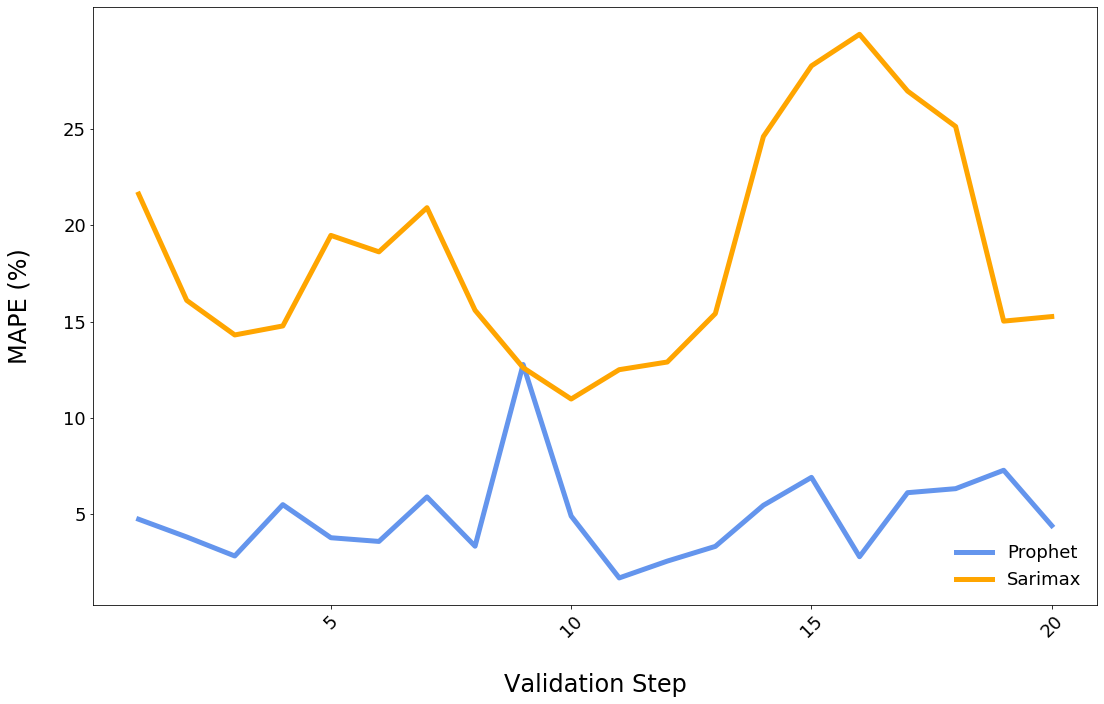

In [125]:
fig = plt.figure(figsize=[18,11])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#plt.title('Walk Forward Validation\n', fontsize=18)
plt.xlabel('\nValidation Step')
plt.ylabel('MAPE (%)\n')
plt.legend(loc='lower right')

prophet_results_x = [x[0].date() for x in results_prophet]
prophet_results_x = pd.DatetimeIndex(prophet_results_x)

xticks = prophet_results_x[4::5]
xlabels = ['5', '10', '15', '20', '10','12']
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks([5, 10, 15, 20, 25], ['5', '10', '15', '20', '25'])



prophet_results_y = [x[1] for x in results_prophet]
prophet_timestamps = [x[0].timestamp() for x in results_prophet]

prophet_z = np.polyfit(prophet_timestamps, prophet_results_y, 1)
prophet_poly_func = np.poly1d(prophet_z)
prophet_trend = [prophet_poly_func(x) for x in prophet_timestamps]

plt.plot(prophet_results_x, prophet_results_y, label='Prophet', c='cornflowerblue', linewidth=5)
#plt.plot(prophet_results_x, prophet_trend, c='b', linestyle='--')

sarima_results_x = [x[0].date() for x in results]
sarima_results_y = [x[1] for x in results]
sarima_timestamps = [x[0].timestamp() for x in results]

sarima_z = np.polyfit(sarima_timestamps, sarima_results_y, 1)
sarima_poly_func = np.poly1d(sarima_z)
sarima_trend = [sarima_poly_func(x) for x in sarima_timestamps]

plt.plot(sarima_results_x, sarima_results_y,label='Sarimax', c='orange', linewidth=5)
leg = plt.legend(loc='lower right', facecolor=None)
leg.get_frame().set_alpha(0.0)
plt.savefig('walk_validation_errors.png', Transparent=True)
#plt.plot(sarima_results_x, sarima_trend, c='red', linestyle='--')